# Rede Neural Recorrente(LSTM) para prever o fechamento das ações de uma empresa, com base no preço das ações nos últimos 60 dias

**Importando as bibliotecas**

In [ ]:
 
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
df = web.DataReader('WDOFUT', data_source='yahoo', start='2012-01-01', end='2020-11-18') 
#Exibindo os dados 
df

RemoteDataError: ignored

In [ ]:
df.shape

(2198, 6)

**Criando gráfico para visualizar as datas**

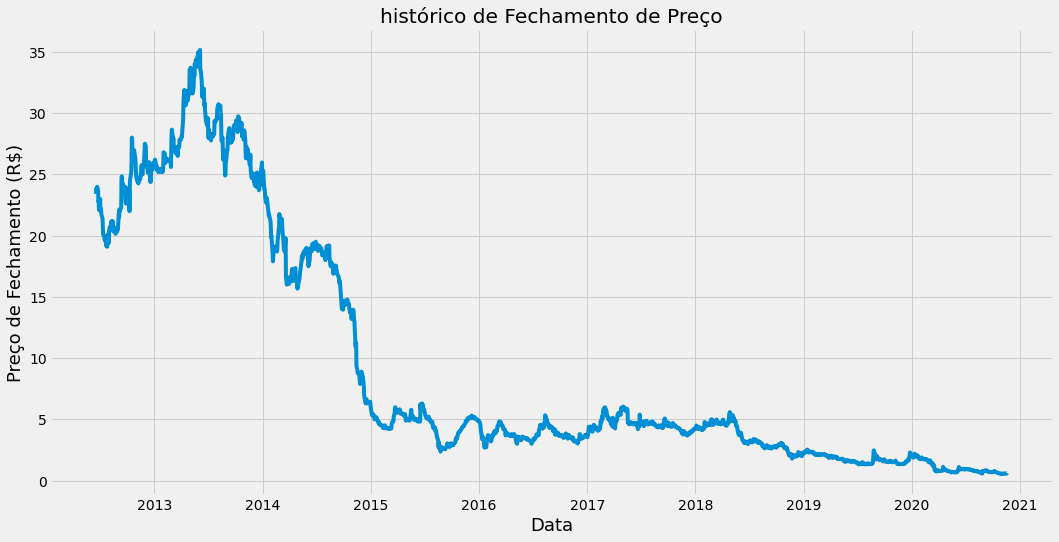

In [ ]:
plt.figure(figsize=(16,8))
plt.title('histórico de Fechamento de Preço')
plt.plot(df['Close'])
plt.xlabel('Data',fontsize=18)
plt.ylabel('Preço de Fechamento (R$)',fontsize=18)
plt.show()

**Criando um novo dataframe**

In [ ]:
#Criando um novo dataframe com somente a coluna 'Close' 
data = df.filter(['Close'])
#Convertendo  o dataframe para um numpy array
dataset = data.values
#obter o número de linhas para conseguir treinar o modelo
training_data_len = math.ceil( len(dataset) *.8)

**Dimensionando o conjunto de dados**

Dimensionando o conjunto de dados para valores binários(0 e 1) antes de utilizar a rede neural

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

**Criando um novo conjunto de dados que contenha os últimos 60 dias para conseguir prever o 61 dia**

In [ ]:
#Criando o conjunto de dados de treinamento em escala 
train_data = scaled_data[0:training_data_len  , : ]
#Dividindo os dados em conjuntos de dados x_train e y_train
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

**Conversão**

Convertendo e matizes numpy para que possam ser usados no LSTM

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)

Remodelando os dados para a forma tridimensional 

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

**MOdelo LSTM**

Construindo um modelo LSTM com 50 neurônios e duas camadas densas, uma com 25 neurônios e outra com 1 neurônio

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

**Compilando o modelo**

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

**Treinamento do Modelo**

In [ ]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

1699/1699 [==============================] - 32s 19ms/step - loss: 0.0029


**Criando um conjunto de dados para teste**

In [ ]:
#Testando o dataset
test_data = scaled_data[training_data_len - 60: , : ]
#Creiando o conjunto de dados x_test e  y_test 
x_test = []
y_test =  dataset[training_data_len : , : ] 
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

**Convertendo o conjunto de dados em numpy array**

In [ ]:
x_test = np.array(x_test)

**Remodelando**

Remodelando os dados para serem tridimensionais para que o LSTM possa executar

In [ ]:
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

**Obtendo os valores previstos, usando dados de teste**

In [ ]:
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)

**Obtendo o erro médio da raiz (RMsE)**

Quanto menor o valor, melhor o modelo

In [ ]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

1.0516469018394103

# **Traçando e visualizando os dados**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


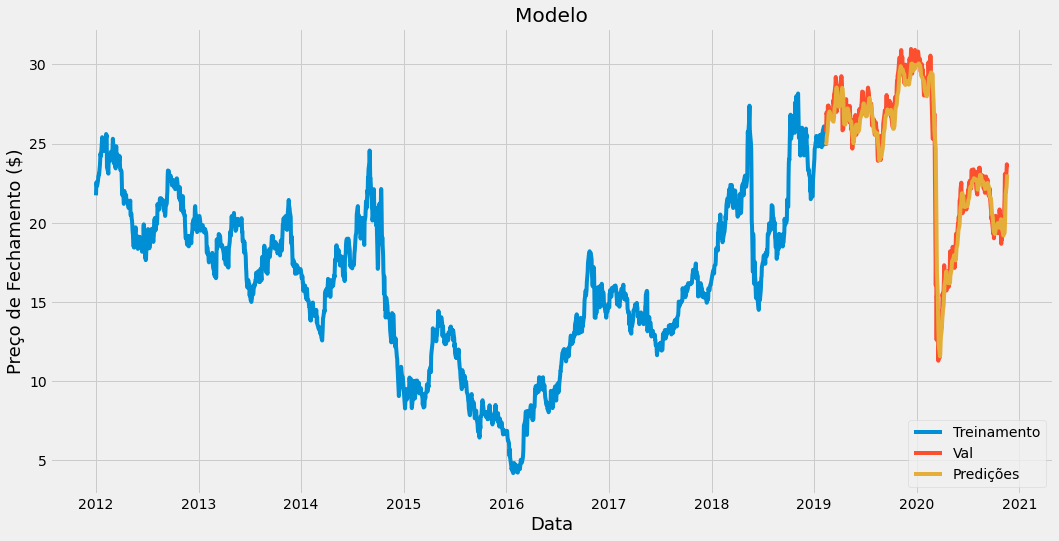

In [ ]:
#Plotando os dados para o gráfico
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualizando os dados
plt.figure(figsize=(16,8))
plt.title('Modelo')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Preço de Fechamento ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Treinamento', 'Val', 'Predições'], loc='lower right')
plt.show()

# **Mostrando os preços válidos previstos**

In [ ]:
valid

,Close,Predictions
Date,,
2019-02-12,25.719999,25.055933
2019-02-13,26.049999,24.998726
2019-02-14,26.950001,25.093216
2019-02-15,26.840000,25.415930
2019-02-18,26.760000,25.788717
...,...,...
2020-11-12,21.910000,21.294847
2020-11-13,22.610001,21.838346
2020-11-16,23.290001,22.268629


# **Prevendo o próximo dia**

In [ ]:
#Pegando a cotação
apple_quote = web.DataReader('PETR4.SA', data_source='yahoo', start='2012-01-01', end='2020-11-18')
#Ciando um novo dataframe
new_df = apple_quote.filter(['Close'])
#Pegando os ultimos 60 dias 
last_60_days = new_df[-60:].values
#Escalando os dados para 0 e 1 
last_60_days_scaled = scaler.transform(last_60_days)
#Criando uma nova lista vazia
X_test = []
#AInserindo os 60 dias na lista
X_test.append(last_60_days_scaled)
#Convertendo o dataset X_test para numpy array 
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Pegando o preço previsto
pred_price = model.predict(X_test)
#Revertendo a escala
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[23.32922]]


verificando o valor real da cotação 

In [ ]:
apple_quote2 = web.DataReader('PETR4.SA', data_source='yahoo', start='2020-11-19', end='2020-11-19')
print(apple_quote2['Close'])

Date
2020-11-19    23.82
2020-11-20    23.82
Name: Close, dtype: float64
